# Huddinge Browser

This is a tool for browsing kmer enrichments in interactive two dimensional plots. This is work in progress so the user interface is a bit involved and the backend is quite fragile, but bare with me. I'm happy to take comments.

Here is a sample and tutorial for use of the system.

In [1]:
import sys
import logging as log
log.basicConfig(level=log.INFO,
                            format='%(asctime)s:%(funcName)s:%(levelname)s:%(message)s')
import numpy as np
import holoviews as hv
import numpy as np
import pandas as pd
hv.extension('bokeh',logo=False)

In [2]:
import huddinge_tsne_browser.tsne_mapper as htm 


In [3]:
!mkdir -p /tmp/kpalin/
%cd /tmp/kpalin
## Temporary directory


/tmp/kpalin


Two main modules of the system are the `huddinge_tsne_browser.tsne_mapper` and `huddinge_tsne_browser.huddinge_browser`.  The tsne_mapper class reads the input files and possibly lays out the input kmers if they have not been laid out before.  Huddinge_browser class is more for interfacing the user.


The distribution comes with 8 mers laid out with TSNE approximating Huddinge distance. Software for calculating all pairs Huddinge distance (and producing appropriate output) is in branch `huddinge_pairs` of git repository `https://github.com/kpalin/MODER.git` and the computation can be done with command line `python huddinge_tsne_browser`.


## Download data

First you need to compute 8 mer counts for some selex [experiment](https://www.ebi.ac.uk/ena/data/view/PRJEB3289)

Larger set can be found from study [PRJEB9797](https://www.ebi.ac.uk/ena/data/view/PRJEB9797) which is related to [Yin, Yimeng, et al. "Impact of cytosine methylation on DNA binding specificities of human transcription factors." Science 356.6337 (2017)](https://www.ncbi.nlm.nih.gov/pubmed/28473536)

In [4]:
PROJECT_ID = "PRJEB9797"

In [5]:
read_data = pd.read_table("http://www.ebi.ac.uk/ena/data/warehouse/filereport?accession={}&result=read_run".format(PROJECT_ID))

In [6]:
import requests
from lxml import etree

In [7]:

project_xml = requests.get("https://www.ebi.ac.uk/ena/data/view/{}&display=xml".format(PROJECT_ID))
project_xml = etree.fromstring(project_xml.content)
sample_names = project_xml.xpath("//XREF_LINK[DB='ENA-SAMPLE']/ID")[0].text

In [8]:

sample_xml = requests.get("https://www.ebi.ac.uk/ena/data/view/{}&display=xml".format(sample_names))
sample_xml = etree.fromstring(sample_xml.content)

In [9]:
sample_titles = {}
for s in sample_xml.xpath("//SAMPLE"):
    p_id = s.find("IDENTIFIERS")
    p_id = p_id.find("PRIMARY_ID")
    title = s.find("TITLE")
    sample_titles[p_id.text] = title.text
    

In [10]:
s = pd.Series(sample_titles)
read_data = read_data.set_index("secondary_sample_accession")
read_data["sample_title"] = pd.Series(sample_titles)


In [11]:
read_data["experiment_type"] = read_data.sample_title.str.extract("^(.*) sample",expand=True)

In [12]:
read_data["experiment_type"].fillna("Missing").value_counts()

mHT-SELEX                                   2654
HT-SELEX                                    2654
bHT-SELEX                                   1464
High salt concentration mHT-SELEX            304
High salt concentration HT-SELEX             304
Klf4 ChIP-seq                                 12
Whole genome bisulfite sequencing (WGBS)      11
Oct4 ChIP-seq                                 11
ATAC-seq                                       6
n-Myc ChIP-seq                                 6
Rabbit IgG ChIP-seq                            4
Mouse IgG ChIP-seq                             3
Goat IgG ChIP-seq                              3
MAX ChIP-exo                                   2
HOXB13 ChIP-seq                                2
Rabbit IgG ChIP-exo                            2
CEBPB ChIP-exo                                 1
Name: experiment_type, dtype: int64

In [13]:
read_data["binder"] = read_data.sample_title.str.extract("sample (.*)$",expand=True)

In [14]:
s = read_data.experiment_type.str.contains("SELEX")
d = read_data.loc[s].sample_alias.str.extract("^(.*)_((FL|eDBD)(_Bis|_Nor)?)_([0-9]+)_",expand=True)
print("SELEX cycle observation counts:")
d[4].fillna(-1).astype(int).value_counts()


SELEX cycle observation counts:


3    2228
4    2228
2    1462
1    1462
Name: 4, dtype: int64

In [15]:
d[1].value_counts()

eDBD        4100
FL          1816
eDBD_Nor     462
eDBD_Bis     462
FL_Bis       270
FL_Nor       270
Name: 1, dtype: int64

In [16]:
pd.crosstab(read_data.loc[s].experiment_type,d[1])

1                                   FL  FL_Bis  FL_Nor  eDBD  eDBD_Bis  \
experiment_type                                                          
HT-SELEX                           908       0       0  1746         0   
High salt concentration HT-SELEX     0       0       0   304         0   
High salt concentration mHT-SELEX    0       0       0   304         0   
bHT-SELEX                            0     270     270     0       462   
mHT-SELEX                          908       0       0  1746         0   

1                                  eDBD_Nor  
experiment_type                              
HT-SELEX                                  0  
High salt concentration HT-SELEX          0  
High salt concentration mHT-SELEX         0  
bHT-SELEX                               462  
mHT-SELEX                                 0

In [17]:
read_data["binder"] = None
read_data.loc[s,"binder"] = d[0]
read_data["binder_type"] = None
read_data.loc[s,"binder_type"] = d[1]


read_data["selex_cycle"] = -1
read_data.loc[s,"selex_cycle"] = d[4].fillna(-1).astype(int)

In [18]:
read_data.selex_cycle.value_counts()

 3    2228
 4    2228
 2    1462
 1    1462
-1      63
Name: selex_cycle, dtype: int64

In [19]:
f = "read_data_{}.tsv".format(PROJECT_ID)
import os.path
if os.path.exists(f):
    read_data = pd.read_table(f,sep="\t")
else:
    read_data.to_csv(f,sep="\t")

# Select reads to fetch

Using HOXB13 and HNF4A selex

In [20]:
s_data = read_data.loc[read_data.binder.str.contains("HOXB13|HNF4A").fillna(False)&(read_data.experiment_type=="HT-SELEX")]
s_data[["binder","binder_type","selex_cycle","experiment_type","read_count","sample_alias"]]

binder binder_type  selex_cycle experiment_type  read_count  \
1696   HNF4A        eDBD            1        HT-SELEX      297070   
1698   HNF4A        eDBD            2        HT-SELEX      324120   
1700   HNF4A        eDBD            3        HT-SELEX      373075   
1702   HNF4A        eDBD            4        HT-SELEX      267281   
1824  HOXB13        eDBD            1        HT-SELEX      201113   
1826  HOXB13        eDBD            2        HT-SELEX      294798   
1828  HOXB13        eDBD            3        HT-SELEX      249143   
1830  HOXB13        eDBD            4        HT-SELEX      208431   

                       sample_alias  
1696   HNF4A_eDBD_1_KO_TACCTT40NCGA  
1698   HNF4A_eDBD_2_KO_TACCTT40NCGA  
1700   HNF4A_eDBD_3_KO_TACCTT40NCGA  
1702   HNF4A_eDBD_4_KO_TACCTT40NCGA  
1824  HOXB13_eDBD_1_KN_TCACTT40NTTG  
1826  HOXB13_eDBD_2_KN_TCACTT40NTTG  
1828  HOXB13_eDBD_3_KN_TCACTT40NTTG  
1830  HOXB13_eDBD_4_KN_TCACTT40NTTG

In [21]:
for i in s_data.fastq_ftp:
    !wget --no-clobber {i}

File ‘ERR1003746.fastq.gz’ already there; not retrieving.

File ‘ERR1003748.fastq.gz’ already there; not retrieving.

File ‘ERR1003750.fastq.gz’ already there; not retrieving.

File ‘ERR1003752.fastq.gz’ already there; not retrieving.

File ‘ERR1003874.fastq.gz’ already there; not retrieving.

File ‘ERR1003876.fastq.gz’ already there; not retrieving.

File ‘ERR1003878.fastq.gz’ already there; not retrieving.

File ‘ERR1003880.fastq.gz’ already there; not retrieving.



In [22]:
print("Samples with null binders:")
read_data.loc[read_data.binder.isnull(),"sample_title"].value_counts()

Samples with null binders:


Klf4 ChIP-seq sample                               12
Oct4 ChIP-seq sample                               11
Whole genome bisulfite sequencing (WGBS) sample    11
n-Myc ChIP-seq sample                               6
ATAC-seq sample                                     6
Rabbit IgG ChIP-seq sample                          4
Mouse IgG ChIP-seq sample                           3
Goat IgG ChIP-seq sample                            3
Rabbit IgG ChIP-exo sample                          2
HOXB13 ChIP-seq sample                              2
MAX ChIP-exo sample                                 2
CEBPB ChIP-exo sample                               1
Name: sample_title, dtype: int64

## Calculate kmer counts

Then calculate 8mer counts for your data. Currently only jellyfish text output is good. (Also note jellyfish needs the `--disk` option for 8 and 7 mers)

In [23]:
%%bash  
K=8

for i in *.fastq.gz
do
    
    OUT=$(basename $i .fastq.gz).${K}mer_counts.jf
    #rm $OUT
    echo $OUT
    if [ ! -e ${OUT} ];
    then
        zcat $i | /usr/bin/time -v jellyfish count --canonical -o $OUT --text -m ${K} -s 1M --bf-size 1G -t 16 --disk /dev/stdin &
    fi
done
wait

ERR1003746.8mer_counts.jf
ERR1003748.8mer_counts.jf
ERR1003750.8mer_counts.jf
ERR1003752.8mer_counts.jf
ERR1003874.8mer_counts.jf
ERR1003876.8mer_counts.jf
ERR1003878.8mer_counts.jf
ERR1003880.8mer_counts.jf


## Read kmer counts and select enriched ones


Calculating 8mer counts.

In [24]:
kmer_size=8
d={}
for _,s in s_data.iterrows():
    f = "{0.run_accession}.{1}mer_counts.jf".format(s,kmer_size)
    _,kmers = htm.read_jf(f)
    d[(s.binder,s.selex_cycle)]=kmers 
    
kmers = pd.DataFrame(d)


Normalize the kmer counts and return 
1. Normalized counts (count of a kmer divided by median count on that cycle)
2. Natural logarithm of fold change of normalized kmer count between each cycle
3. Mean of the log fold changes
4. z-score of the log fold change (mean divided by standard deviation)


In [25]:
def normalize_selex(kmers,pseudocount=1.0):
    """Normalize kmer counts. kmer.shape == (kmers,cycles).
    
    Return value is a tuple of 
    (median normalized counts, 
       log fold change for each cycle, 
       mean fold change per cycle,
       fold change z-score) """
    import pandas as pd 
    
    assert kmers.shape[0]> kmers.shape[1]
    kmers = kmers.sort_index(axis=1)+pseudocount

    # Median normalisation
    norm_cnt = kmers/kmers.median(axis=0)

    # log fold change per cycle
    ln_fold_change = np.log(norm_cnt).diff(axis=1)
    ln_fold_change = ln_fold_change.drop(ln_fold_change.columns[0],axis=1)

    # Mean fold change per cycle
    mean_fold = ln_fold_change.mean(axis=1)

    fold_z = mean_fold/ln_fold_change.std(axis=1)
    
    d = {}
    for i,c in enumerate(norm_cnt.columns):
        d[(c,"normalized")] = norm_cnt[c]
        if i>0:
            d[(c,"ln_fold")] = ln_fold_change[c]
            
    d["mean_ln_fold"] = mean_fold
    d["fold_z"] = fold_z
    return pd.DataFrame(d)
    d = {"normalized":norm_cnt,
         "ln_fold":ln_fold_change}
    return d#pd.DataFrame(d)
#         "mean_ln_fold":mean_fold,
#         "fold_z":fold_z}
    return d#pd.DataFrame(d)
    return norm_cnt,ln_fold_change,mean_fold,fold_z

In [27]:
data = dict()
for binder in ["HOXB13","HNF4A"]:
    data[binder] = normalize_selex(kmers[binder],0.0)
data = pd.concat(data)

/home/kpalin/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log


(-5, 5)

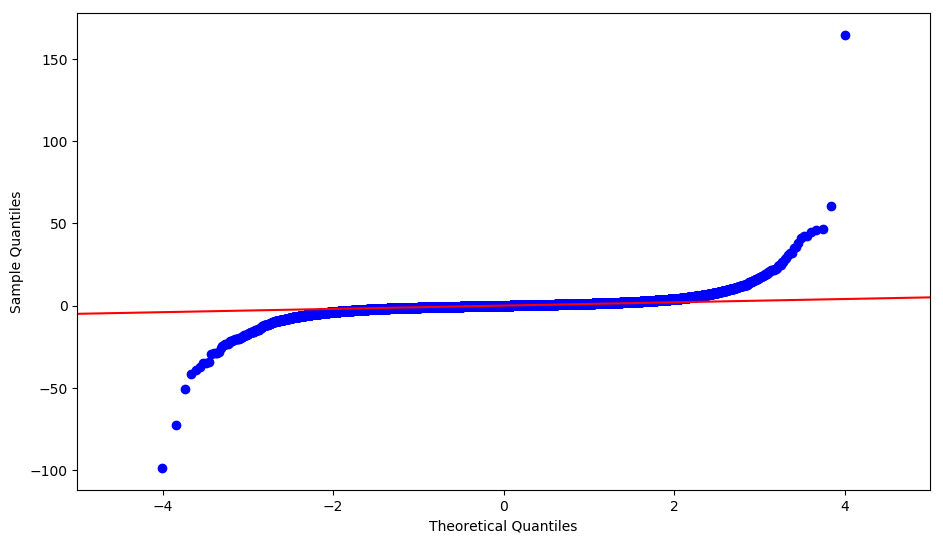

In [28]:
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
#sns.distplot(data.loc["HNF4A"].fold_z)
_=sm.qqplot(data.loc["HNF4A"].fold_z,line="45")
plt.xlim(-5,5)

In [29]:
data.groupby(level=0).describe().T.unstack().T

fold_z  mean_ln_fold  (1, normalized)  (2, ln_fold)  \
HNF4A  count  32896.000000  32896.000000     32896.000000  3.289600e+04   
       mean       0.000957     -0.005373         1.164305 -9.178676e-03   
       std        2.601035      0.103570         0.732092  1.315844e-01   
       min      -98.802662     -0.569459         0.094118 -1.790306e+00   
       25%       -0.757590     -0.068472         0.819608 -8.893057e-02   
       50%       -0.035453     -0.003335         1.000000 -3.534053e-03   
       75%        0.747458      0.058005         1.266667  7.700092e-02   
       max      164.595471      1.194481        21.243137  1.770319e+00   
HOXB13 count  32895.000000  32895.000000     32896.000000  3.289600e+04   
       mean      -0.007351     -0.005578         1.239904          -inf   
       std        2.314340      0.105317         0.901854           NaN   
       min     -190.023693     -0.449025         0.128205          -inf   
       25%       -0.634858     -0.072549         0.769231 -1.367110e-01   
       50%       -0.135913     -0.015680         1.000000 -2.105341e-02   
       75%        0.455293      0.047468         1.384615  9.965008e-02   
       max      103.337053      0.823739        21.519231  9.948796e-01   

              (2, normalized)  (3, ln_fold)  (3, normalized)  (4, ln_fold)  \
HNF4A  count     32896.000000  3.289600e+04     32896.000000  32896.000000   
       mean          1.178279 -8.762015e-03         1.205886      0.001822   
       std           0.850480  1.384567e-01         1.027323      0.155980   
       min           0.098182 -1.891523e+00         0.097087     -1.271178   
       25%           0.792727 -8.671722e-02         0.763754     -0.086636   
       50%           1.000000 -3.493035e-03         1.000000      0.004247   
       75%           1.298182  7.414665e-02         1.349515      0.089799   
       max          27.192727  1.673653e+00        34.071197      1.502660   
HOXB13 count     32896.000000  3.289600e+04     32896.000000  32896.000000   
       mean          1.259291           inf         1.324070      0.002038   
       std           1.142738           NaN         1.828370      0.140275   
       min           0.000000 -6.565896e-01         0.090426     -0.961359   
       25%           0.730769 -9.078183e-02         0.712766     -0.085701   
       50%           1.000000 -4.264399e-03         1.000000      0.000135   
       75%           1.431624  8.013754e-02         1.468085      0.087589   
       max          58.196581           inf       139.101064      0.791120   

              (4, normalized)  
HNF4A  count     32896.000000  
       mean          1.307186  
       std           1.708386  
       min           0.049020  
       25%           0.720588  
       50%           1.000000  
       75%           1.426471  
       max          59.941176  
HOXB13 count     32896.000000  
       mean          1.387249  
       std           2.705964  
       min           0.060000  
       25%           0.700000  
       50%           1.000000  
       75%           1.486667  
       max         254.720000

In [30]:
data.loc[(slice(None),"CAAAGGTC"),]

fold_z  mean_ln_fold  (1, normalized)  (2, ln_fold)  \
       Sequence                                                          
HNF4A  CAAAGGTC  2.297281      1.194481         1.454902      0.641609   
HOXB13 CAAAGGTC  0.482189      0.016757         0.576923      0.014706   

                 (2, normalized)  (3, ln_fold)  (3, normalized)  (4, ln_fold)  \
       Sequence                                                                 
HNF4A  CAAAGGTC         2.763636      1.673653        14.734628      1.268182   
HOXB13 CAAAGGTC         0.585470      0.052488         0.617021     -0.016924   

                 (4, normalized)  
       Sequence                   
HNF4A  CAAAGGTC        52.372549  
HOXB13 CAAAGGTC         0.606667

ValueError: range parameter must be finite.

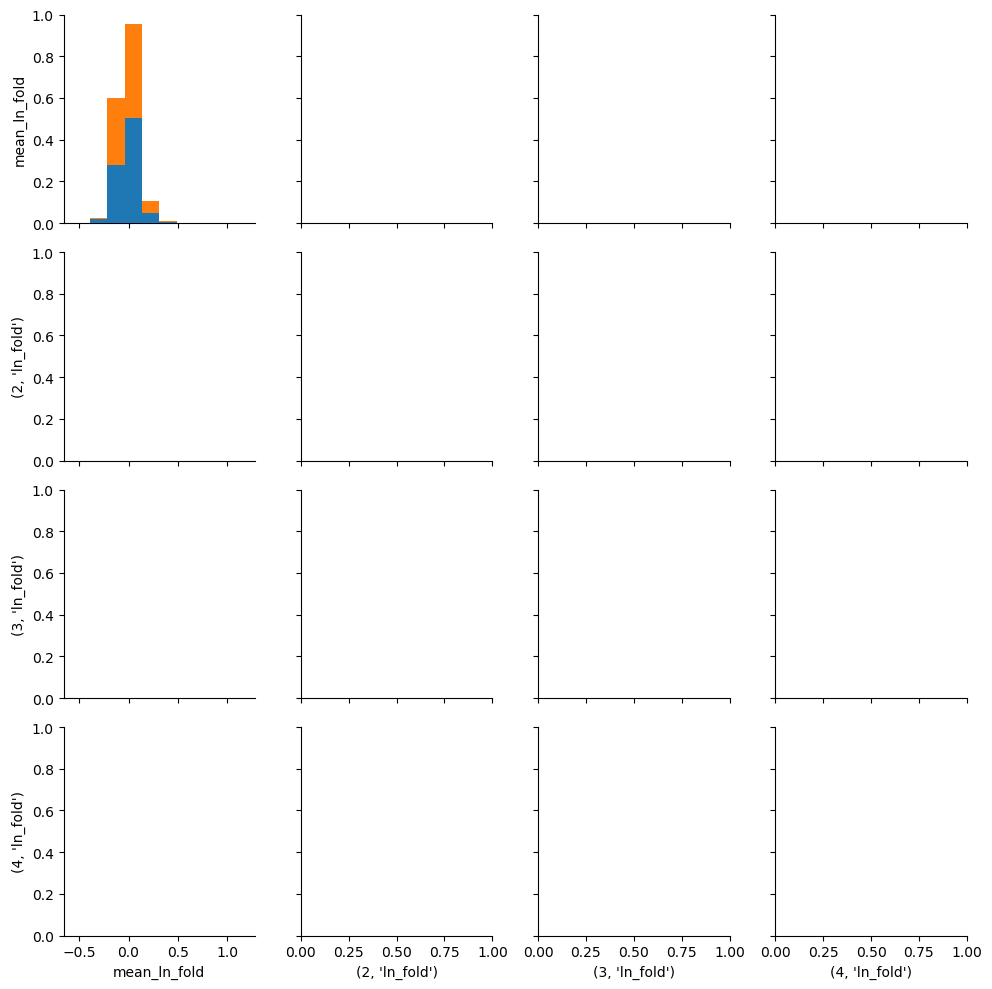

In [34]:
data.reset_index(0)[["level_0"]]
sns.pairplot(data.reset_index(0),hue="level_0",vars=["mean_ln_fold",(2,"ln_fold"),(3,"ln_fold"),(4,"ln_fold")],
            plot_kws=dict(linewidth=0,s=1.0,alpha=0.5))

In [36]:
TF="HOXB13"
TF = "HNF4A"

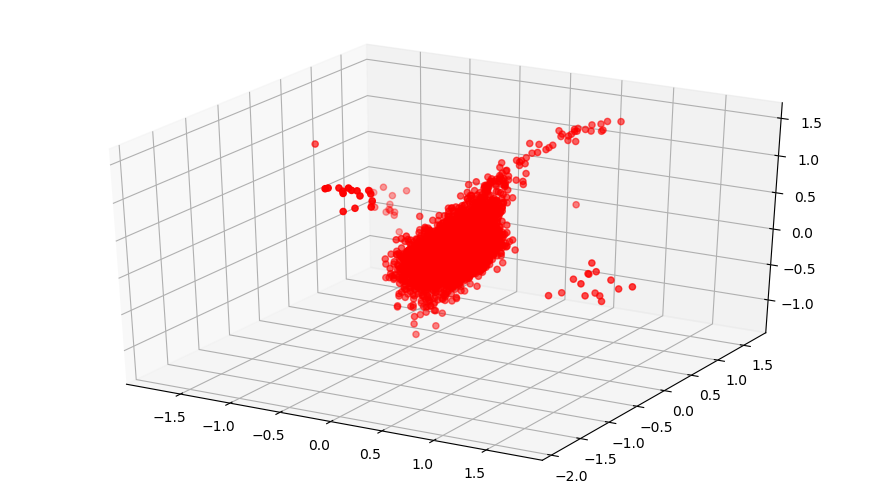

In [37]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d    

%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.scatter(data.loc[TF][(2,"ln_fold")],
           data.loc[TF][(3,"ln_fold")], 
           data.loc[TF][(4,"ln_fold")],c='r', marker='o')


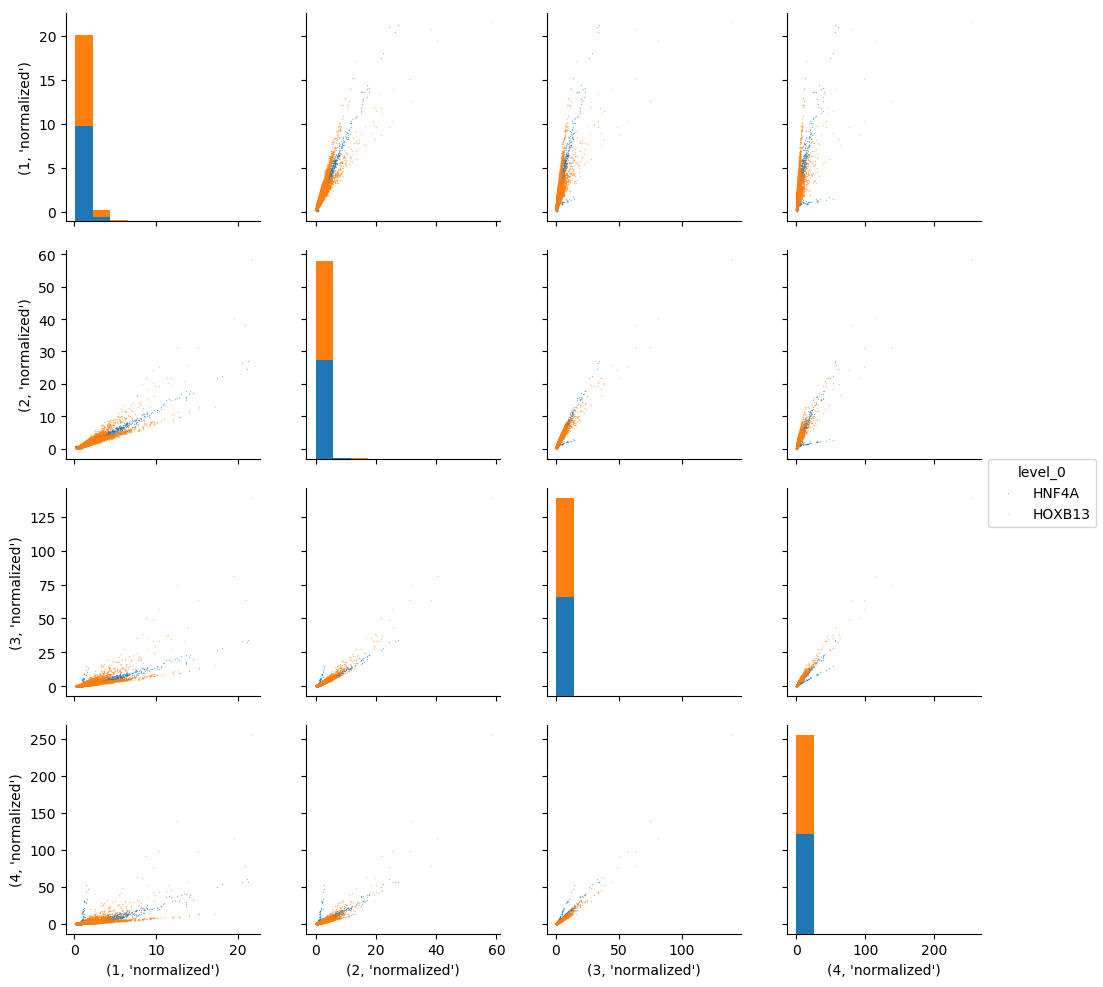

In [38]:
data.reset_index(0)[["level_0"]]
sns.pairplot(data.reset_index(0),hue="level_0",
             vars=[(1,"normalized"),(2,"normalized"),(3,"normalized"),(4,"normalized")],
            plot_kws=dict(linewidth=0,s=1.0,alpha=0.5))

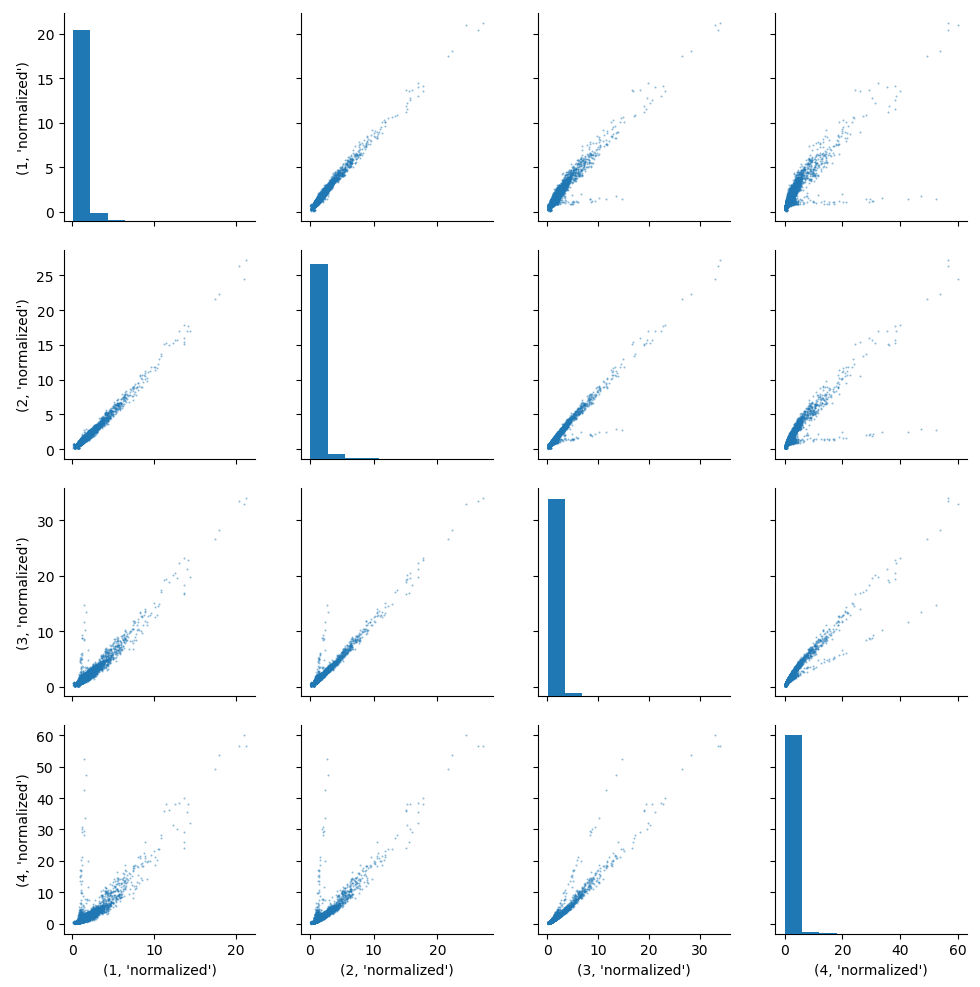

In [39]:
data.reset_index(0)[["level_0"]]
sns.pairplot(data.loc["HNF4A"],
             vars=[(1,"normalized"),(2,"normalized"),(3,"normalized"),(4,"normalized")],
            plot_kws=dict(linewidth=0,s=2.0,alpha=0.5))

In [40]:
hv.operation.gridmatrix?
hv.Dataset

holoviews.core.data.Dataset

In [41]:
x=data.loc["HNF4A"][[(1,"normalized"),(2,"ln_fold"),(3,"ln_fold"),(4,"ln_fold")]]
x.columns = map(str,x.columns)
ds = hv.Dataset(x)
grid = hv.operation.gridmatrix(ds, diagonal_type=hv.Scatter)
grid.options('Scatter', tools=['hover', 'box_select'], bgcolor='#efe8e2', fill_alpha=0.2, size=4)

:GridMatrix   [X,Y]
   :Scatter   [(4, 'ln_fold')]   ((4, 'ln_fold'))

In [42]:
print(grid)

:GridMatrix   [X,Y]
   :Scatter   [(4, 'ln_fold')]   ((4, 'ln_fold'))


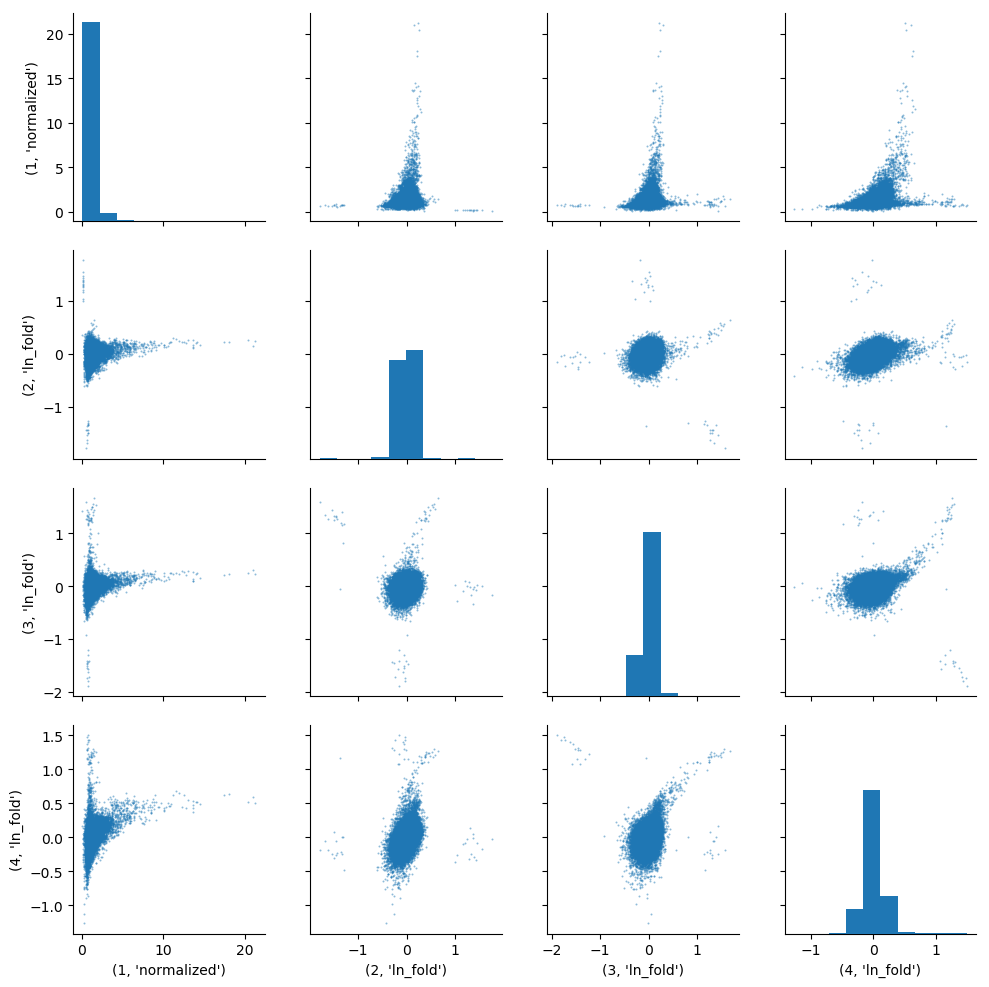

In [43]:
data.reset_index(0)[["level_0"]]
sns.pairplot(data.loc["HNF4A"],
             vars=[(1,"normalized"),(2,"ln_fold"),(3,"ln_fold"),(4,"ln_fold")],
            plot_kws=dict(linewidth=0,s=2.0,alpha=0.5))

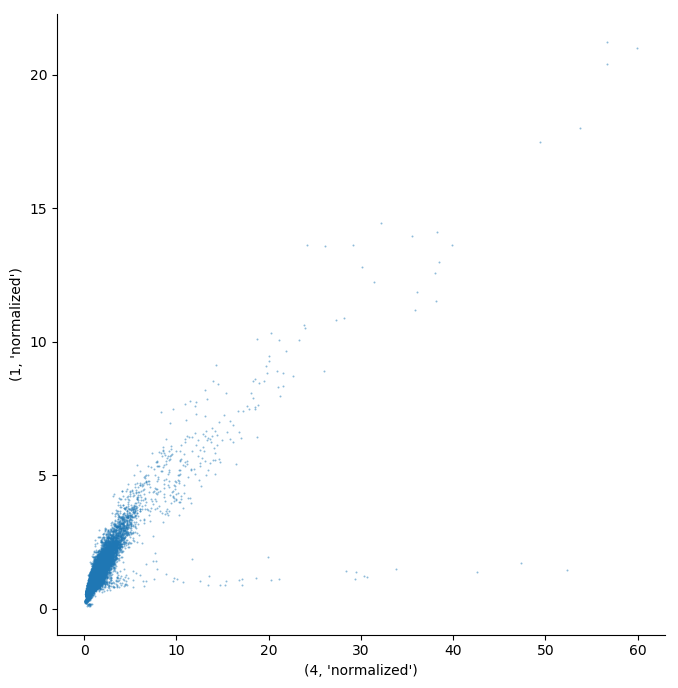

In [44]:
data.reset_index(0)[["level_0"]]
sns.pairplot(data.loc["HNF4A"],
             y_vars=[(1,"normalized")],
             x_vars=[(4,"normalized")],size=7,
            plot_kws=dict(linewidth=0,s=2.0,alpha=0.5))

In [45]:
sns.distplot(x[(2,"ln_fold")],label="2 ln fold")
sns.distplot(x[(3,"ln_fold")],label="3 ln fold")
sns.distplot(x[(4,"ln_fold")],label="4 ln fold")
plt.legend()

KeyError: (2, 'ln_fold')

In [ ]:
sns.distplot(x[(1,"normalized")],label="1 normalized",bins=300)
sns.distplot(x[(2,"normalized")],label="2 normalized",bins=300)
sns.distplot(x[(3,"normalized")],label="3 normalized",bins=300)
sns.distplot(x[(4,"normalized")],label="4 normalized",bins=300)
plt.legend()
plt.xlim(0,5)

In [ ]:
x= data.loc["HNF4A"]
x.loc[(x[(1,"normalized")] < 3) & (x[(4,"normalized")] >10)]

In [ ]:
sns.jointplot((1, "normalized"),"mean_ln_fold",data.loc["HNF4A"],s=1)

In [ ]:
?sns.pairplot

In [ ]:
sm.robust.scale.huber([0.640516,1.672956	,1.266397	])

In [ ]:
pd.Series([0.640516,1.672956	,1.266397	]).std()

In [ ]:
np.random.normal(size=100).std()

In [ ]:
def _random_est():
    x=np.random.normal(scale=10.0,size=(13,10))
    l,s = sm.robust.scale.huber(x)
    return (l,s,np.median(x),x.std())

In [ ]:
_random_est()

In [ ]:
data.loc[("HNF4A","CAAAGGTC"),]

Select kmers that enrich during selex with 99% confidence. i.e. enrichment z-score > 2.58

In [ ]:
GAUSSIAN99 = 2.58
z = data["fold_z"].unstack().T
selected_kmers = z.loc[z.max(axis=1)>GAUSSIAN99]
selected_kmers_HNF4A = z.loc[z.HNF4A>GAUSSIAN99]
selected_kmers_HOXB13 = z.loc[z.HOXB13>GAUSSIAN99]

## Initialize layout

First you need to lay out your kmers. You can compute huddinge distances between all pairs of given kmers with accompanying `all_pairs_huddinge` command. Its output can be laid out with command line `huddinge_tsne_browser`command and the resulting should be given to `TsneMapper("kmer_layout.tsnet")`. TSNE layout of all 8mers takes more than an hour.  


For 8mers, the layout has already been done and the layout can be downloaded from [here](http://www.cs.helsinki.fi/u/kpalin/kmer8_iters4k.tsne.gz).


In [ ]:
import os.path
if not os.path.exists("all8mers_min_rev_complement.tsne"):
    #!wget --no-clobber http://www.cs.helsinki.fi/u/kpalin/kmer8_iters4k.tsne.gz
    !wget --no-clobber http://www.cs.helsinki.fi/u/kpalin/all8mers_min_rev_complement.tsne.gz
    !gunzip  all8mers_min_rev_complement.tsne.gz


In [ ]:
%pwd

In [ ]:
try:
    from importlib import reload
except ImportError:
    pass


## Read distances



In [ ]:
#%pdb off
#tsne = htm.TsneMapper("kmer8_iters4k.tsne",force_distances=True)


%pdb off
tsneD =dict()
for tf in ("HOXB13","HNF4A"):
    fname = "kmer8_iters4k.tsne"
    fname = "all8mers_min_rev_complement.dists"
    tsneD[tf] = htm.TsneMapper(fname,force_distances=True)

#tsne.subset_sequences(list(selected_kmers.index))
tsneD["HOXB13"].subset_sequences(list(selected_kmers_HOXB13.index))
tsneD["HNF4A"].subset_sequences(list(selected_kmers_HNF4A.index))


In [ ]:
selected_kmers_HOXB13.head()

In [ ]:
data.head()

Find maximally enriched sequences in local (in huddinge space) context.

In [ ]:
huddinge_mat = pd.DataFrame(tsneD[TF].matrix,
                            index=tsneD[TF].sequences[0].squeeze(),
                            columns=tsneD[TF].sequences[0].squeeze())

In [ ]:
def get_local_maxima(skmers,n=10,max_local_dist=1.0):
    candidates = skmers.sort_values(ascending=False).iteritems()
    #Find local maxima
    local_maxima  = [ next(candidates)[0] ]
    for kmer,v in candidates:
        neighbours = skmers[huddinge_mat.loc[kmer]<=max_local_dist]
        neighbours = neighbours.drop(kmer)
        if neighbours.max() < v:  # All neighbours are lower, hence we have local maxima
            local_maxima.append(kmer)
        else:
            log.info("Skipping non maximal locus {}".format(kmer))
        if len(local_maxima)>=n:
            break
    return local_maxima

In [ ]:
def get_local_maxima_dev(skmers,n=10,max_local_dist=1.0):
    candidates = skmers.sort_values(ascending=False).iteritems()
    #Find local maxima
    local_maxima  = [ ]
    rep_maxima = pd.Series(None,index=skmers.index)
    for kmer,v in candidates:
        if rep_maxima.loc[[kmer]].notnull()[0]: continue
        neighbours = skmers[huddinge_mat.loc[kmer]<=max_local_dist]
        neighbours = neighbours.drop(kmer)
        if len(neighbours)==0:
            log.info("No {:.0f} hudding distance neighbours for kmer {}".format(max_local_dist,kmer))
            rep_maxima.loc[kmer] = kmer
            continue
        if neighbours.max() < v:  # All neighbours are lower, hence we have local maxima
            local_maxima.append(kmer)
            new_neighbours = set(neighbours.index)-set(rep_maxima.loc[rep_maxima.notnull()].index)
            rep_maxima.loc[list(new_neighbours)+[kmer]] = kmer
            
        else:  
            allocated_neighbours = set(neighbours[neighbours>=v].index)&set(rep_maxima.loc[rep_maxima.notnull()].index)
            c_reps = rep_maxima.loc[list(allocated_neighbours)]
            
            if c_reps.nunique()!=1:
                log.info(str(c_reps.drop_duplicates()))
            
            new_neighbours = set(neighbours.index)-set(rep_maxima.loc[rep_maxima.notnull()].index)
            rep_maxima.loc[list(new_neighbours)+[kmer]] = skmers.loc[c_reps].argmax()
            
            #print(rep_maxima.loc[list(allocated_neighbours)])
            #log.info("Skipping non maximal locus {}".format(kmer))
    rep_maxima.index.name="kmer"
    rep_maxima.name="representative"        
    return local_maxima,rep_maxima

In [ ]:
def revComplement(s):
    "Reverse complement string s"

    return "".join(revComplement.WC[x] for x in s[::-1])

revComplement.WC = dict(list(zip("ACGTN.", "TGCAN.")))


In [ ]:
data.head()

In [ ]:
#loc_max = get_local_maxima(data.loc["HOXB13"].loc[selected_kmers_HOXB13.index,"mean_ln_fold"],
#                           n=10)

if TF == "HOXB13":
    loc_max,loc_max_reps  = get_local_maxima_dev(data.loc["HOXB13"].loc[selected_kmers_HOXB13.index,"mean_ln_fold"],
                                             n=10)
elif TF=="HNF4A":
    loc_max,loc_max_reps  = get_local_maxima_dev(data.loc["HNF4A"].loc[selected_kmers_HNF4A.index,"mean_ln_fold"],
                                             n=10)
else: 
    raise ValueError()

In [ ]:
data.loc[TF].sort_values("mean_ln_fold",ascending=False).head()

In [ ]:
data.loc[TF].loc[loc_max]

In [ ]:
huddinge_mat.loc[loc_max,loc_max]

In [ ]:
open("/home/kpalin/test.seq","w").write("\n".join(map(revComplement,loc_max)+loc_max))
%cd ~/software/MODER
!./all_pairs_huddinge  ~/test.seq 
testD = htm.TsneMapper("huddinge.dists")
testM = pd.DataFrame(testD.matrix,index=testD.sequences[0],columns=testD.sequences[0])
x=testM.stack()
x.index.names=["kmer1","kmer2"]
x=x.reset_index(name="HuddingeD")
x
hv.HeatMap(x).opts(plot=dict(colorbar=True,tools=["hover"]))

Find optimal radial spacing for the local maxima (anchors). The r distance is the enrichment value.  The objective is the sum of sequared errors between huddinge distance and euclidean distance of the anchors.

In [ ]:
def polar2cartesian(r,thetas):
    import numpy as np
    import pandas as pd
    import scipy.spatial.distance as ssd

    
    cartes = np.array([r*np.cos(thetas), r*np.sin(thetas)]).T
    if hasattr(thetas,"index"):
        cartes = pd.DataFrame(cartes,columns=["x","y"],index=thetas.index)
    return cartes


def circle_distances(r_thetas):

    import numpy as np
    import scipy.spatial.distance as ssd

    r,thetas = r_thetas[0],r_thetas[1:]
    cartes = np.array([r*np.cos(thetas), r*np.sin(thetas)]).T

    D = ssd.pdist(cartes,"euclidean")
    return D

def circle_map_anchors(anchors):

    
    
    import scipy.spatial.distance as ssd
    jitter = np.random.uniform(-0.3,0.3,size=(len(anchors),len(anchors)))
    np.fill_diagonal(jitter,0)
    jittered_dist = huddinge_mat.loc[anchors,anchors] + (jitter + jitter.T)/2.0
    jittered_D = ssd.squareform(jittered_dist)
    
    def ssq_distance_diff(r_thetas):
        return ( (circle_distances(r_thetas)-jittered_D)**2).sum()
    
    import scipy.optimize as so
    init_params = np.append( np.array([np.max(jittered_D)/2]), np.random.uniform(0,2*np.pi,size=len(anchors)))
    
    bounds = [(0.1,None)] + [(0.0,2.0*np.pi)]*len(anchors)
    
    #opt = so.minimize(ssq_distance_diff,x0=init_params,bounds = bounds)
    opt = so.basinhopping(ssq_distance_diff,x0=init_params,minimizer_kwargs = dict(bounds = bounds))
    
    print(opt.message)
    r = opt.x[0]
    thetas = pd.Series(opt.x[1:],index=anchors)
    D = pd.DataFrame(ssd.squareform(circle_distances(opt.x)),index=anchors,columns=anchors)
    _n = len(anchors)*(len(anchors)-1)/2
    return r,thetas,D,opt.fun/_n,((D-jittered_dist)**2).sum().sum()/2
    

In [ ]:
%pdb off
ret = circle_map_anchors(loc_max[:10])
ret[3:]

In [46]:
def align_logo(seqs):
    "Align fixed length kmers to the first one and generate a count matrix"
    import pandas as pd
    seqs = [pd.get_dummies( pd.Categorical(list(x),categories=["A","C","G","T"]) ) for x in seqs]
    
    m_len = len(seqs[0])
    motif = seqs[0].reindex(index=pd.RangeIndex(-m_len,   m_len*2-1),fill_value=0)
    for s in seqs[1:]:
        score,shift = max( ((motif.shift(shift)*s).sum().sum(),shift) for shift in range(-m_len+1,m_len-1) )      
        
        rc_s = s.copy()
        rc_s.index = list(s.index)[::-1]
        rc_s.columns = list(s.columns)[::-1]

        
        rc_score,rc_shift = max( ((motif.shift(shift)*rc_s).sum().sum(),shift) for shift in range(-m_len+1,m_len-1) )      
        if rc_score>score:
            print("rc better")
            shift,score,s = rc_shift,rc_score,rc_s.sort_index()
        motif.loc[-shift:-shift+ m_len-1] += s.set_index(pd.RangeIndex(-shift,  -shift+ m_len))
        
    return motif.loc[motif.sum(axis=1)>0].copy()


def plot_polar(tf,theta_angle,representatives=None):
    "Arguments: Name of the binder tf and list of representative kmers (with angle positions)"
    %opts Points (cmap="inferno_r") [tools=['box_select', 'lasso_select'] scaling_factor=50 width=500 height=500]  { +axiswise -framewise }
    #%%opts Histogram (cmap="inferno_r") { +axiswise -framewise }
    
    from holoviews import streams
    
    
    

    # Position anchors
    enrichment_r = data.loc[tf].loc[theta_angle.index,"mean_ln_fold"]
    anchors_x = polar2cartesian(enrichment_r,theta_angle)
    anchors_x["enrichment"] = enrichment_r

    if representatives is None:
        # Select the closest (in hudding distance) local maxima as representative. 
        # Break ties according to enrichment
        representatives = huddinge_mat.loc[enrichment_r.index]
        representatives.index.name="representative"
        representatives.columns.name="kmer"

        representatives = representatives[representatives==representatives.min()].T.stack()
        representatives.name="distance"

        #Position others
        #single_rep = representatives.groupby("kmer").apply(lambda x:x.sample(1))
        single_rep = representatives.reset_index("representative")
        single_rep["rep_enrichment"] = enrichment_r[single_rep.representative].values
        single_rep = single_rep.groupby("kmer").apply(lambda x:x.sort_values("rep_enrichment").tail(1))
        single_rep = single_rep.reset_index(0, drop=True)#.drop("rep_enrichment",axis=1)


        #single_rep.index.names=["d"] + list(single_rep.index.names)[1:]
        #single_rep=single_rep.reset_index("d",drop=True).reset_index("representative")
    else:
        single_rep = pd.DataFrame(representatives)
        single_rep["distance"] = [huddinge_mat.at[x,y] for x,y in single_rep.representative.iteritems()]
    
    single_rep["enrichment"] = data.loc[tf].loc[single_rep.index,"mean_ln_fold"].values
    single_rep["theta"] = theta_angle[single_rep.representative].values


    # Add angular jitter
    jitter_span = 2*np.pi/100.0*single_rep.distance


    single_rep[["x","y"]] = polar2cartesian(single_rep.enrichment,
                    single_rep.theta + np.random.uniform(low=-jitter_span,high=jitter_span,size=len(jitter_span)) )



    # Declare some points
    x=single_rep.reset_index()
    max_distance = x.distance.max()
    print(max_distance)
    #x["distance"] = x.distance.apply("{:.0f}".format)
    points = hv.Points(x,kdims=["x","y"],
          vdims=[ _x for _x in x.columns if _x not in ["x","y"]],
              extents=(-1,-1,1,1)
         ).opts(plot=dict(tools=["hover",'box_select', 'lasso_select'],
                          width=600,height=500,
                          scaling_factor=13,size_index="enrichment",
                          show_grid=True,color_index="distance",
                          colorbar=True,
                          #  cmap='PiYG', color_levels=int(max_distance+1.1)
                         ),norm=dict(axiswise=True,framewise=False))
    #points.opts(plot=dict(aspect_weight=1.0,weight=1.0))
    
    
    
    #points = hv.Points(tsneD[tf].embedding.join(data.loc[tf]).reset_index(),
    #                   kdims=kdims,
    #                   vdims=['mean_ln_fold',"Sequence"]).relabel(tf)

    # Declare points as source of selection stream
    selection = streams.Selection1D(source=points)

    ENRICHMENT = "enrichment"
    # Write function that uses the selection indices to slice points and compute stats
    def selected_histogram(index):
        selected = points.iloc[index]
        if index:
            #label = str(selected.dframe().mean(axis=0))[:15]
            label = "Mean {} {}: {:.3g}".format(tf,ENRICHMENT,
                                             selected.dframe()[ENRICHMENT].mean())
            #label = 'Mean x, y: %.3f, %.3f' % tuple(selected.array().mean(axis=0))
        else:

            selected = points
            label = 'No selection'
        from holoviews.operation import histogram

        h = histogram(selected,dimension=ENRICHMENT,dynamic=False).relabel(label)#.opts(style=dict(color='red'))
        return h

    def selected_table(index):
        selected = points.iloc[index]
        if index:
            label = "Mean {} {}: {:.3g}".format(tf,ENRICHMENT,
                                             selected.dframe()[ENRICHMENT].mean())
        else:

            selected = points
            label = 'No selection'
        #from holoviews.operation import histogram
        #h = histogram(selected,dynamic=False).relabel(label)#.opts(style=dict(color='red'))
        t= selected.table()
        html = t.dframe().head().drop(["x","y"],axis=1).set_index("kmer").to_html()
        return hv.Div("<div>{}</div>".format(html)).opts(plot=dict(width=200))
        #t.data = t.data.drop(["x","y","theta"],axis=1)
        return t
    
    def selected_matrix(index):
        import pandas as pd
        import holoviews as hv
        selected = points.iloc[index]
        if not index:
            selected = points
        d= selected.data.kmer
        
        if len(d) < 50:
            counts = align_logo(list(d)).T
        else:
            counts = pd.DataFrame(tuple(x) for x in d).apply(lambda x:x.value_counts(),axis=0)
            #counts = counts.fillna(0)        

        counts = counts.reindex(columns = pd.RangeIndex(-counts.shape[1]/2,int(counts.shape[1]*1.5)),fill_value=0)
        counts.columns = map(str,counts.columns)
            
        ##return hv.Div(counts.astype(int).to_html(notebook=True)).opts(plot=dict(width=400,height=700))
        return hv.Table(counts)

    def show_logo(mat,height=100,width=300):
        import svgwrite as sw
        #assert len(mat)==4
        mat = (mat+1.0/(mat.shape[0]*mat.shape[1]))
        mat = mat/mat.sum().max()
        w = mat.shape[1]*15
#        dr=sw.Drawing(size=("%dpt"%(w),"30pt"))
        dr=sw.Drawing(size=("{:d}pt".format(width),"{:d}pt".format(height)))
        #dr.add(dr.rect((0,0),(4100,1130),fill="pink"))
        g = sw.container.Group()
        cmap = dict(zip("ACGT",["green","blue","orange","red"]))

        for c,clab in enumerate(mat.columns):
        
            xpos = 10*int(c)
            ypos = 10
            #g.add(dr.text(str(c),fill="black" )).translate(xpos,ypos)
            

            for i,base in enumerate(mat.index):
                yscale = mat.loc[base,clab]

                t=g.add(dr.text(base,fill=cmap.get(base) ))
                t.translate(xpos,ypos)
                t.scale(sx=1,sy=yscale)
                ypos-=(10*yscale)
        dr.add(g)
        g.scale(sx=width/(len(mat.columns)*10.0),sy=height/(10.0))
        return hv.Div(dr.tostring()).opts(plot=dict(width=width,height=height))
        
    
    def selected_heatmap(index):
        import pandas as pd
        import holoviews as hv
        selected = points.iloc[index]
        if not index:
            selected = points
        d= selected.data.sort_values("enrichment",ascending=False).kmer
        if len(d) < 50:
            counts = align_logo(list(d)).T
        else:
            counts = pd.DataFrame(tuple(x) for x in d).apply(lambda x:x.value_counts(),axis=0)
            #counts = counts.fillna(0)        
#        counts = pd.DataFrame(tuple(x) for x in d).apply(lambda x:x.value_counts(),axis=0)
        counts = counts.fillna(0)
        try:
            return show_logo(counts,height=100)
        except (ImportError,AttributeError):
            counts = counts.stack().reset_index()
            counts.columns = map(str,counts.columns)

            t = hv.Table(counts,kdims=["level_1","level_0"])
            t = t.redim(level_1="Position",level_0="Base")


            return t.to.heatmap().opts(plot={"colorbar":True,"tools":["hover"],"invert_yaxis":True,
                                            "sizing_mode":"fixed",
                                             "width":400,"height":200})
        
    # Combine points and DynamicMap
    

    r=points.hist(dimension=ENRICHMENT)* hv.Ellipse(0,0,1.0) << hv.DynamicMap(selected_histogram, streams=[selection]) 
    r = r.relabel(tf)
    r= r+hv.DynamicMap(selected_table, streams=[selection]) + \
        hv.DynamicMap(selected_matrix, streams=[selection]) + \
        hv.DynamicMap(selected_heatmap, streams=[selection])

    #r._selection = selection
    
    return r

## TODO


Document:

- Color is the distance to representative
- 10 local maximas
- CIrcle radius 0.5
- Visualize also z-scores(?)
- Allow selection by enrichment score (Circles on different r)



In [ ]:
%pdb off

#%debug 
p = plot_polar(TF,ret[1],loc_max_reps).cols(2)#.hist(dimension="enrichment")
p

Note: a given kmer can be more enriched than its nearest local optimum!

Currently each kmer is allocated to the highest local optimum 

In [122]:
TF

'HNF4A'

In [128]:
data.loc[TF].sort_values("mean_ln_fold")

fold_z  mean_ln_fold  (1, normalized)  (2, ln_fold)  \
Sequence                                                          
TTTTAAAA -0.907135     -0.542811         0.273438     -0.411696   
TAAATTTA -1.293569     -0.496208         0.324219     -0.289371   
AAATTTTA -2.543218     -0.488534         0.570312     -0.395391   
AAAATTTT -2.225312     -0.476412         0.285156     -0.433857   
TTTATAAA -1.589130     -0.448816         0.281250     -0.147197   
CTATAAAA -1.220924     -0.441252         0.714844     -0.260829   
AAATCTAT -1.633455     -0.433420         0.644531     -0.298367   
ATAAAAAA -2.052735     -0.432553         0.750000     -0.232852   
TTATATAA -0.731617     -0.431901         0.285156     -0.254809   
AAAATTCT -3.629021     -0.424825         0.523438     -0.290932   
AAATTCTC -1.921929     -0.418970         0.617188     -0.255017   
AAAAATTT -4.835982     -0.417046         0.562500     -0.317649   
AAAGCTTT -3.239381     -0.412149         0.503906     -0.310063   
AAATATTT -1.990666     -0.403549         0.343750     -0.601317   
TAAAAAAA -1.284271     -0.400314         0.648438     -0.130965   
AAATTATT -1.736485     -0.396932         0.593750     -0.407756   
TCCAGAAA -2.034491     -0.393005         0.792969     -0.282484   
AAAATTTA -1.851511     -0.392640         0.570312     -0.199018   
AAATATAT -5.173407     -0.386226         0.714844     -0.440522   
AAAAAAAT -1.479567     -0.383952         0.632812     -0.145540   
CTTATAAA -0.951071     -0.382440         0.691406     -0.288529   
AGAAATCT -2.748036     -0.381733         0.613281     -0.377879   
TTATAAAA -1.493211     -0.381216         0.566406     -0.231676   
AAAAATCC -5.600379     -0.380780         0.886719     -0.318390   
AGAATCCC -2.130203     -0.378801         0.972656     -0.309473   
TTAAAAAA -8.658809     -0.378652         0.683594     -0.427825   
GATTTTAA -1.368753     -0.374821         0.675781     -0.272688   
AGAATTCC -2.376383     -0.372888         0.671875     -0.252905   
AATTTTCT -4.802954     -0.366529         0.585938     -0.422420   
AAATCTCT -1.046286     -0.366529         0.644531     -0.489821   
...            ...           ...              ...           ...   
ACCTTTGC  1.709515      0.636817         1.304688      0.222883   
AGGGTCAA  1.627419      0.637054         1.113281      0.243549   
GCAATTGC  0.946054      0.638649         0.097656      0.343487   
AAGTCCAT  1.415124      0.666060         0.875000      0.122602   
GGGTCCAA  1.473903      0.707890         1.156250      0.153311   
AAGTCCAC  1.862583      0.734105         1.105469      0.314811   
AAGGTCAT  1.381497      0.741825         1.039062      0.125105   
GGGGTCAA  1.581929      0.774240         1.945312      0.212459   
AAGGTCAC  1.940049      0.778572         1.027344      0.326432   
AAAGGTCG  1.495845      0.798010         1.230469      0.195652   
CCAAAGTC  1.842902      0.823706         1.054688      0.307769   
GGTCCAAA  1.697178      0.893039         1.050781      0.288490   
ACTTTGGA  1.884795      0.902967         0.890625      0.356217   
ACCTTTGG  1.710391      0.908993         1.117188      0.297063   
CCTTTGGA  1.581597      0.910940         1.085938      0.247798   
ACTTTGAC  1.928657      0.925030         1.156250      0.372144   
AAGTCCAA  2.153566      0.928707         0.906250      0.436464   
AGTCCAAA  1.895496      0.943393         0.894531      0.371588   
AGGTCAAA  1.991626      0.968441         1.101562      0.407553   
AAGGTCAA  1.941688      0.977126         1.121094      0.396521   
GACTTTGA  1.870788      0.978753         0.902344      0.382256   
GGGTCAAA  1.815848      0.995782         1.421875      0.371503   
CCTTTGAC  2.135708      1.019625         1.378906      0.471767   
CAAAGTCC  2.083197      1.034912         1.507812      0.479198   
ACCTTTGA  1.940122      1.065112         1.234375      0.449430   
AAAGTCCA  2.247212      1.074504         1.214844      0.551454   
CTTTGGAC  2.369917      1.085128         1.125000      0.57

In [130]:
data.loc[TF].loc[loc_max]

fold_z  mean_ln_fold  (1, normalized)  (2, ln_fold)  \
Sequence                                                           
CCGCCCTC   2.588416      0.331155         4.132812      0.265829   
GGGAGGGA   2.682489      0.317088         5.175781      0.230595   
CCCACCCA   2.791539      0.312951        12.218750      0.221608   
GGAGGGCA   3.265374      0.307474         2.464844      0.236726   
ACGACGTG  11.660697      0.298796         0.937500      0.316255   
CGTCCCCC   2.773733      0.297501         4.070312      0.262071   
CCCGTCCC   2.915826      0.286226         3.972656      0.262793   
CCTGCCCC   3.854639      0.267037         5.175781      0.206403   
AGGGGCAA  12.186045      0.262161         1.421875      0.238223   
GGTCACGA   2.878219      0.257917         0.976562      0.232261   
CACCCCAC   2.769007      0.254831         8.496094      0.218646   
AGGGGAGG   2.683805      0.252901         4.769531      0.152985   
CGTCGTCC   6.811257      0.252308         1.000000      0.228924   
CCTTGCCC   4.409521      0.250932         2.539062      0.211689   
CGGTGGAC   3.904743      0.249332         1.343750      0.182209   
ACGTTACG   4.359179      0.247821         1.039062      0.286701   
CGCCGTAC   4.270355      0.241445         1.359375      0.289180   
ACATGACC   4.407559      0.236889         1.203125      0.208392   
CACGTACG   5.070200      0.235590         1.328125      0.182606   
GGTCACAC   3.106323      0.235520         1.078125      0.165162   
GTCACGTA   7.761494      0.232836         0.921875      0.200738   
GGGAGGAC   2.827941      0.230919         1.664062      0.183885   
CGTACACG   6.407772      0.229308         1.382812      0.199665   
GATACGGC   3.870245      0.227169         1.058594      0.191955   
CCCTTTGC   3.320655      0.223687         1.496094      0.255263   
AGGTCGAC   2.932850      0.223356         0.871094      0.145226   
CGTGTCAC   4.689292      0.222677         1.105469      0.203585   
CGAACGGA  34.748439      0.222444         0.835938      0.228681   
ACGTATCA   3.133220      0.215634         1.003906      0.219245   
CCGTCGCC   5.854288      0.213833         1.492188      0.255999   
...             ...           ...              ...           ...   
CGCTCTCC   3.483324      0.117491         1.515625      0.127086   
GCGGTCCA   2.733531      0.116583         1.234375      0.079831   
CAATGGTC   4.051443      0.115110         0.804688      0.145976   
CAGTGATG   2.935547      0.113718         1.082031      0.117870   
AGGCATGA   4.587184      0.113030         1.007812      0.105158   
CCCTTGGA  11.568366      0.112888         1.011719      0.104521   
AATGATGC  65.396091      0.108893         0.921875      0.109919   
AGGCGAGA   4.223418      0.106299         1.000000      0.132172   
CACATCAC  14.687464      0.105700         1.882812      0.108135   
CAGTGGCG   4.033125      0.104076         1.492188      0.086379   
TAGCGTAA  10.074732      0.102471         0.921875      0.113434   
CGTTCATC   4.130385      0.101434         1.003906      0.125093   
TCGATCGA   3.006020      0.096139         0.285156      0.122954   
TAACGGAA   6.054840      0.094077         0.820312      0.083001   
GTGTGCTA   5.912822      0.092661         1.292969      0.096468   
ATGTACTG   3.935092      0.091009         0.898438      0.099825   
CGACGCCG   3.891100      0.090520         1.234375      0.068932   
ACCGCATC   8.508529      0.088395         1.421875      0.079712   
ACGCAACA   3.176385      0.082399         1.695312      0.111314   
GCATTGGC   2.654514      0.080117         1.277344      0.080237   
CGGAACCG   3.098360      0.074056         0.968750      0.088102   
TCATTACA   2.583634      0.072434         0.804688      0.081697   
CCACAGTC   3.190614      0.071030         1.296875      0.049231   
TGACCACA   2.622654      0.069902         1.261719      0.097767   
TAGCATGA   4.620626      0.068453         0.937500      0.071759   
GCATCCTA   3.103768      0.066665         0.890625      0.044507   
C